In [1]:
%cd ..
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # use cpu because I'm training on gpu

# from thumbs.experiments.pokemjon_big_both import PokemonExperiment
from thumbs.experiments.pokemon_conditional_outline import PokemonExperiment
from thumbs.train import load_weights
from thumbs.viz import show_samples, visualize_preprocessed_image
from thumbs.data import load_and_preprocess_image
import tensorflow as  tf
import numpy as np
import matplotlib.pyplot as plt

from thumbs.util import unnormalize_image, normalize_image


/home/anthony/workspace/yt-data


/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Images in /home/anthony/workspace/yt-data/data/pokemon
['282-mega.jpg', '582.jpg', '340.jpg', '570.jpg', '136.jpg', '531-mega.jpg', '335.jpg', '96.jpg', '581.jpg', '153.jpg']
Found 820 total files
Found 819 jpgs


  0%|          | 0/819 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

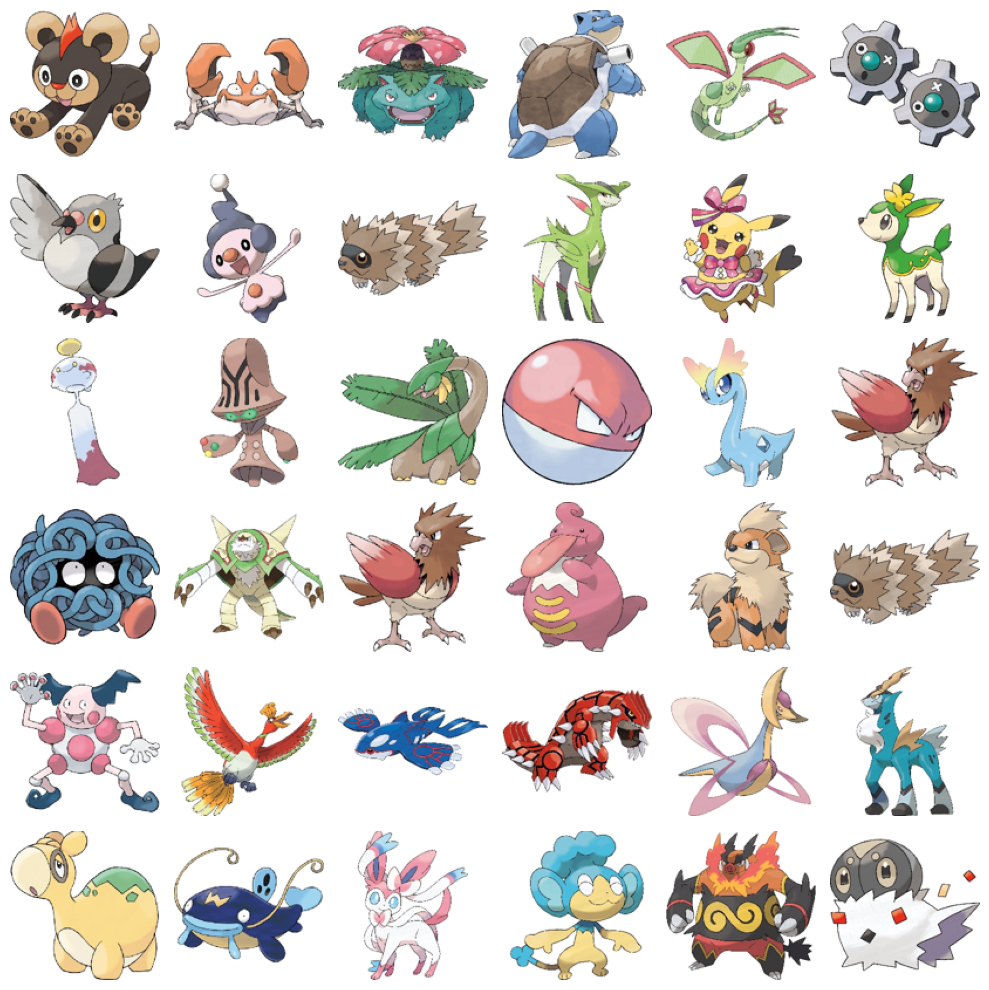

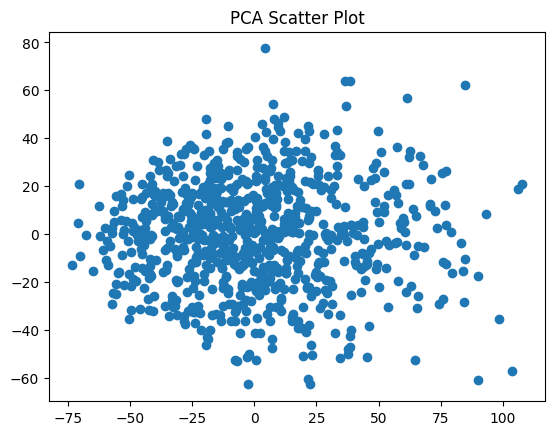

Model: "discriminator"
________________________________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                                     Output Shape                                Param #                 Connected to                                                      
 input_1 (InputLayer)                                             [(None, 128, 128, 3)]                       0                       []                                                                
                                                                                                                                                                                                        
 input_2 (InputLayer)                                             [(None, 128, 128, 1)]                       0                       []                                     

2023-07-05 20:55:47.469756: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "generator"
________________________________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                                     Output Shape                                Param #                 Connected to                                                      
 outline input (InputLayer)                                       [(None, 128, 128, 1)]                       0                       []                                                                
                                                                                                                                                                                                        
 conv2d_4 (Conv2D)                                                (None, 64, 64, 64)                          1600                    ['outline input[0][0]']                    

In [2]:
exp = PokemonExperiment()
mparams = exp.get_mutable_params()
m = exp.get_model(mparams[0]).build()
load_weights(m.generator, f'{exp.get_params().weight_path}_gen')
load_weights(m.discriminator, f'{exp.get_params().weight_path}_dis')
images = exp.get_data()

# Make sure data augmentation is working

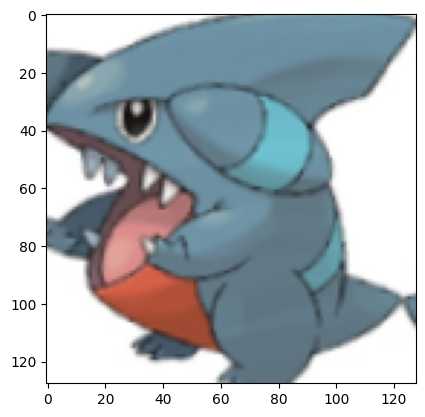

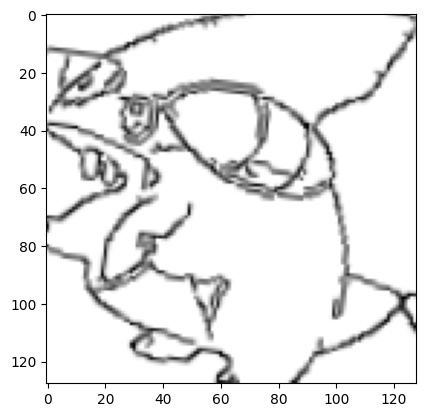

In [3]:

dataset = tf.data.Dataset.from_tensor_slices(images)
# image, outline = dataset.__iter__().__next__()
data = exp.prepare_data(dataset, exp.get_mutable_params()[0])
image, outline = data.__iter__().__next__()

plt.imshow(unnormalize_image(image.numpy()[0]))
plt.show()
plt.imshow(unnormalize_image(outline.numpy()[0]), cmap='gray')
plt.show()

# Make a fake pokemon and judge it

<Figure size 640x480 with 0 Axes>

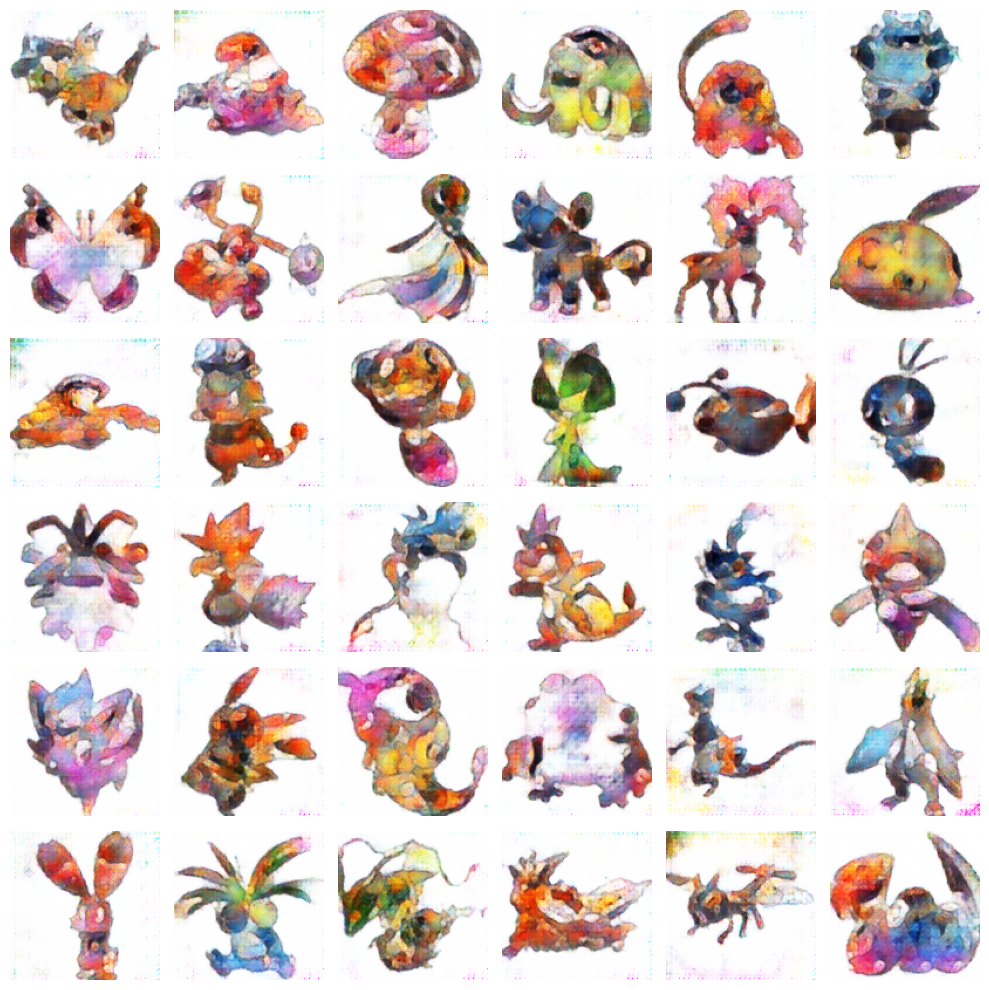

In [4]:

def get_labels(n: int):
    # get n random samples from self.labels
    normal_flying = exp.lookup(['normal', 'flying'])
    return np.array([normal_flying for _ in range(n)])


show_samples(m.generator, exp.get_params().latent_dim, rows=6, cols=6, file_name="tmp.jpg", dir="/tmp", label_getter=exp.get_random_labels)
# show_samples(m.generator, exp.get_params().latent_dim, rows=6, cols=6, file_name="tmp.jpg", dir="/tmp", label_getter=get_labels)

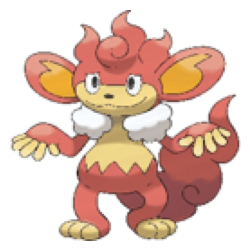

1/1 [==============================] - 0s 58ms/step


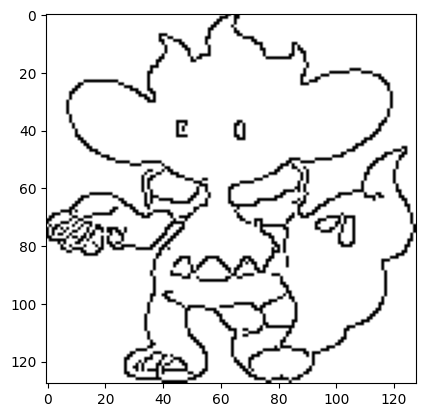

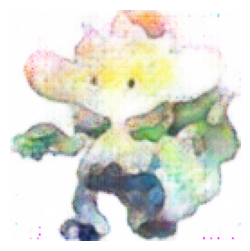

1/1 [==============================] - 0s 27ms/step
[[0.00013774]]
1/1 [==============================] - 0s 27ms/step
[[8.877153e-08]]


In [7]:
random_image = images[0][10]
random_outline = images[1][10]
visualize_preprocessed_image(random_image, (3,3))

plt.imshow(unnormalize_image(random_outline), cmap='gray')


noise = np.random.normal(0, 1, (1, 100))
generated_thumbnails = m.generator.predict([noise, np.expand_dims(random_outline, axis=0)])
visualize_preprocessed_image(generated_thumbnails[0], (3,3))
print(m.discriminator.predict([generated_thumbnails, np.expand_dims(random_outline, axis=0)]))


different_random_outline = images[1][11]
print(m.discriminator.predict([generated_thumbnails, np.expand_dims(different_random_outline, axis=0)])) # See if it can tell the difference between different outlines


In [ ]:
# mean of a lot of generated images
noise = np.random.normal(0, 1, (800, 100))
generated_thumbnails = m.generator.predict(noise)
print(np.mean(m.discriminator.predict(generated_thumbnails)))

# Try my own outline

(128, 128, 1)
1/1 [==============================] - 0s 49ms/step


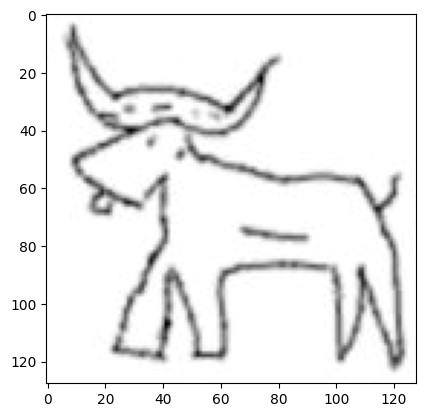

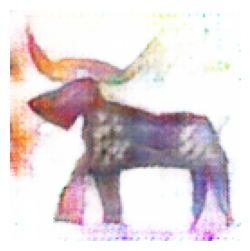

1/1 [==============================] - 0s 26ms/step
[[2.9758976e-07]]


In [13]:
from PIL import Image
path = '/home/anthony/windows/Desktop/pokemon_outline.jpg'
img =  normalize_image(np.asarray(Image.open(path)))
img = np.expand_dims(img, axis=-1)
# img = tf.keras.layers.Dropout(0.8)(img, training=True)
print(img.shape)

plt.imshow(img, cmap='gray')

noise = np.random.normal(0, 1, (1, 100))
generated_thumbnails = m.generator.predict([noise, np.expand_dims(img, axis=0)])
visualize_preprocessed_image(generated_thumbnails[0], (3,3))
print(m.discriminator.predict([generated_thumbnails, np.expand_dims(random_outline, axis=0)]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


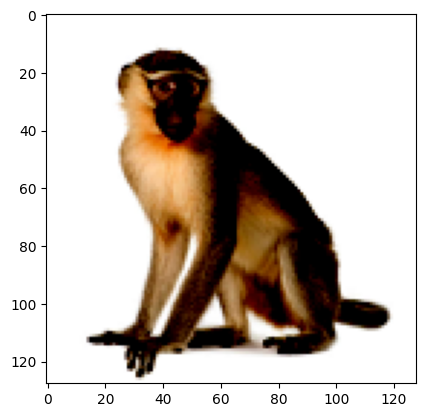

In [16]:
import cv2
def create_outline(image, threshold1=600, threshold2=None):
    thresholds = [10, 100, 400, 800, 1000]
    if threshold2 is None:
        threshold2 = np.random.choice(thresholds)

    edges = cv2.bitwise_not(cv2.Canny(image, threshold1=threshold1, threshold2=threshold2))
    edges = np.expand_dims(edges, axis=-1)
    return edges

img = '/home/anthony/windows/Downloads/monkey.jpg'
img = load_and_preprocess_image(img, (128, 128, 3))
plt.imshow(img)

(128, 128, 1)


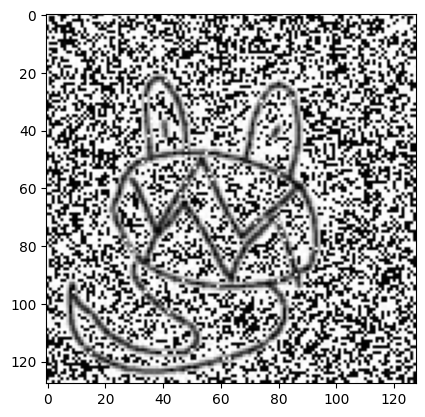

In [10]:

dropped = tf.keras.layers.GaussianNoise(0.04)(img, training=True)
print(dropped.shape)
plt.imshow(unnormalize_image(dropped.numpy()), cmap='gray')

# Determine attribution

In [6]:

# Define a function to compute the attribution maps using Gradient*Input method
def compute_attribution_map(image: np.ndarray):
    image = tf.convert_to_tensor(image)
    with tf.GradientTape() as tape:
        tape.watch(image)
        output = m.discriminator(image)
    
    gradients = tape.gradient(output, image)
    attribution_map = gradients * image
    
    return attribution_map

def show_attribution(input_image):
    preprocessed_image = np.expand_dims(input_image, axis=0)  # Add batch dimension

    # Compute the attribution map for the input image
    attribution_map = compute_attribution_map(preprocessed_image)
    # Convert the attribution map to a grayscale image
    attribution_map = np.mean(attribution_map, axis=-1, keepdims=True)

    # Normalize the attribution map to [0, 1]
    attribution_map -= np.min(attribution_map)
    attribution_map /= np.max(attribution_map)

    # Resize the attribution map to the original image size for visualization
    attribution_map = tf.image.resize(attribution_map, size=(128, 128)).numpy()


    # Convert them back to 0,255. The pokemon images look better that way, just keep
    # the attribution map consistent
    input_image = ((input_image + 1) * 127.5).astype(np.uint8)


    # Display the original image and the attribution map
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(input_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(attribution_map.squeeze(axis=0), cmap='bwr')
    axes[1].set_title('Attribution Map')
    axes[1].axis('off')
    plt.show()


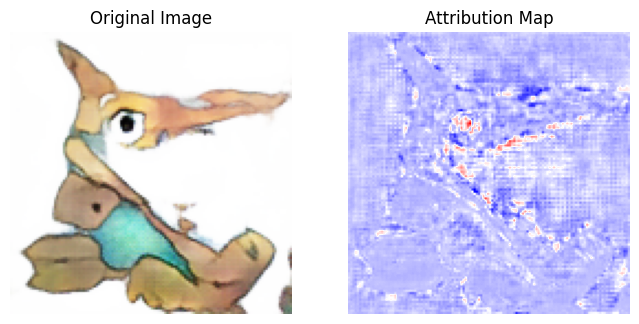

In [55]:

show_attribution(generated_thumbnails[0])

### Sanity check against an absurd image

1/1 [==============================] - 0s 26ms/step
[[-13.387986]]


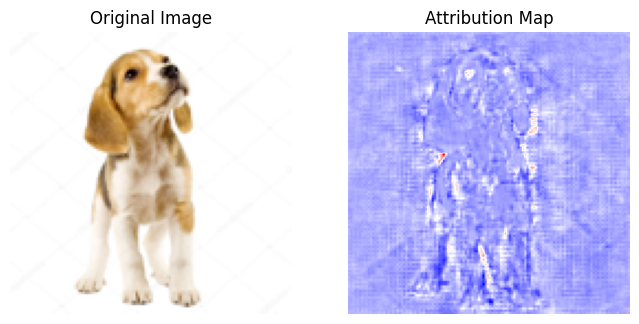

In [8]:
# load 
egg_jpg = '/home/anthony/windows/Downloads/dog_white.jpg'
egg = load_and_preprocess_image(egg_jpg, (128, 128, 3))

print(m.discriminator.predict(np.expand_dims(egg, axis=0)))
show_attribution(egg)

# Judge a real pokemon

In [1]:
from thumbs.data import get_pokemon_data256
images = get_pokemon_data256(exp.get_params().img_shape)
images.shape

ModuleNotFoundError: No module named 'thumbs'

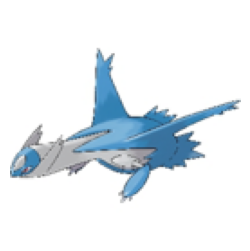

1/1 [==============================] - 0s 25ms/step
[[-5.0586567]]


In [27]:
real_pokemon = images[np.random.randint(0, images.shape[0], 1)]
visualize_preprocessed_image(real_pokemon[0], (3,3))

print(m.discriminator.predict(real_pokemon))



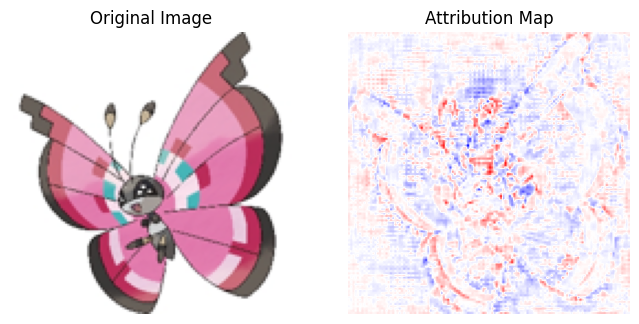

In [11]:

show_attribution(real_pokemon[0])

In [12]:

# Mean of the entire real set
print(np.mean(m.discriminator.predict(images)))

26/26 [==============================] - 2s 64ms/step
3.6592631


# Inspect hidden layer output

Layer 1 of 6, shape (None, 6, 6, 256), name conv2d_transpose/BiasAdd:0


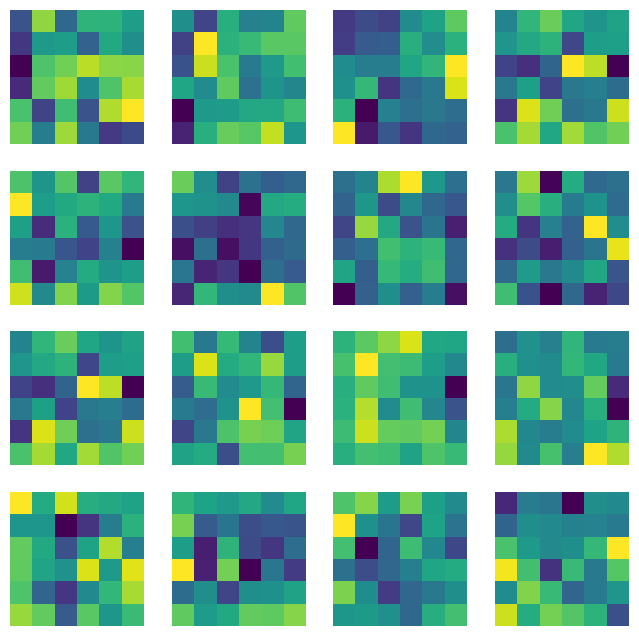

Layer 2 of 6, shape (None, 30, 30, 192), name conv2d_transpose_1/BiasAdd:0


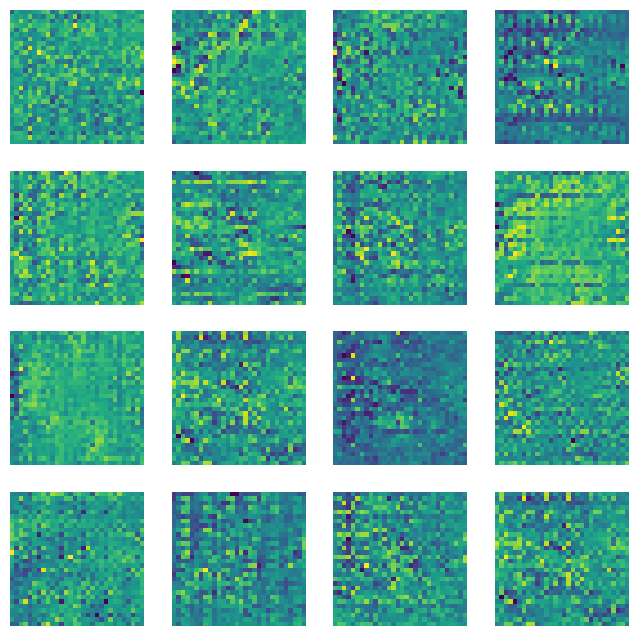

Layer 3 of 6, shape (None, 63, 63, 128), name conv2d_transpose_2/BiasAdd:0


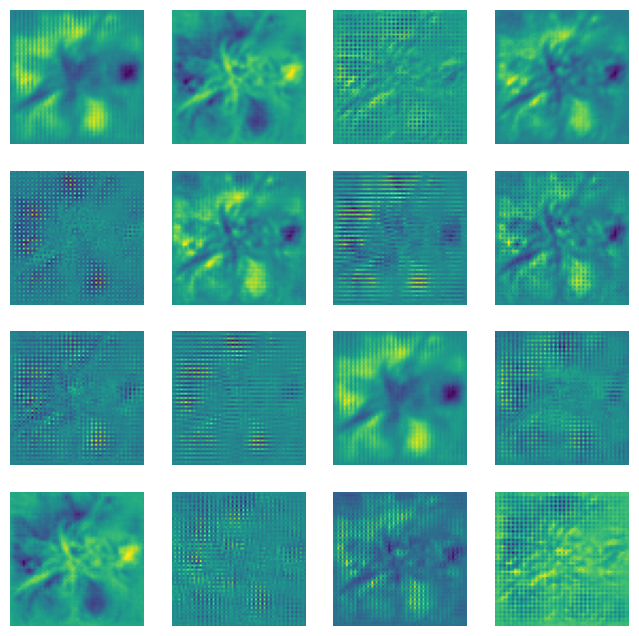

Layer 4 of 6, shape (None, 64, 64, 64), name conv2d_transpose_3/BiasAdd:0


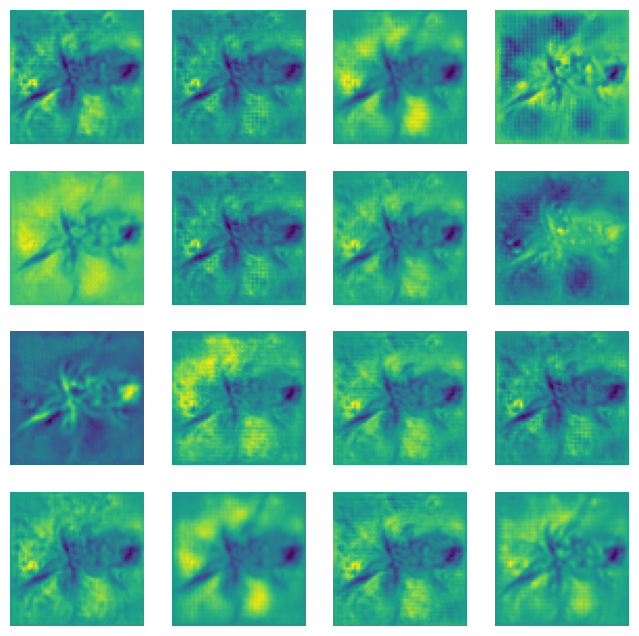

Layer 5 of 6, shape (None, 128, 128, 3), name conv2d_transpose_4/BiasAdd:0


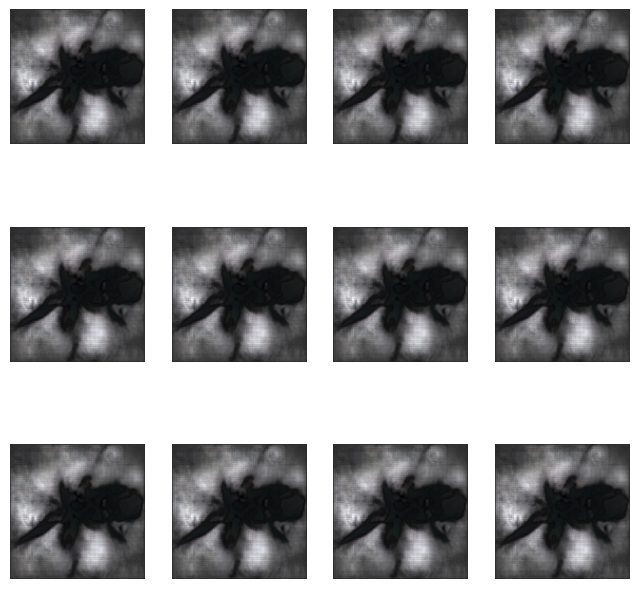

Layer 6 of 6, shape (None, 128, 128, 3), name activation/Tanh:0


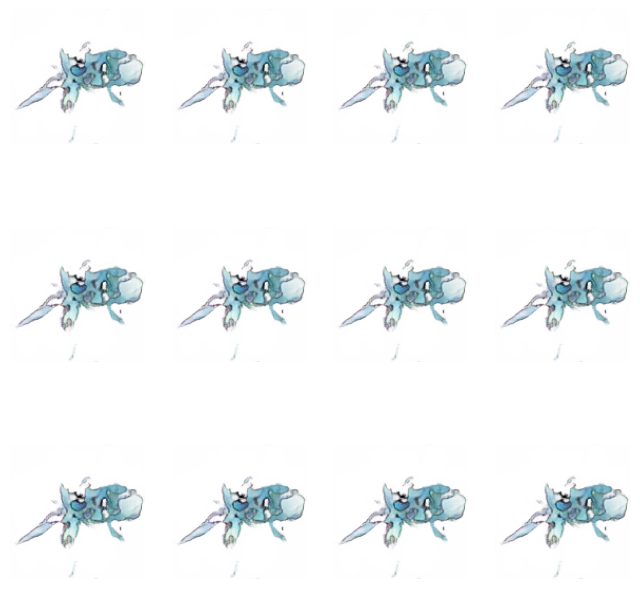

In [13]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def get_intermediate_models(model):
    intermediate_models = []
    # layers_to_get = [2,5,8,11, 12]
    for i in range(len(model.layers)):
        # only pick models that have conv2d_transpose_1 or tanh in the name
        if 'conv2d_transpose' in model.layers[i].output.name.lower() or 'tanh' in model.layers[i].output.name.lower():
            print(model.layers[i])
            intermediate_model = Model(inputs=model.input, outputs=model.layers[i].output)
            intermediate_models.append(intermediate_model)
    return intermediate_models


generator = m.generator
intermediate_models = get_intermediate_models(generator)
noise = np.random.normal(0, 1, (1, 100))
for i, intermediate_model in enumerate(intermediate_models):
    print(f'Layer {i+1} of {len(intermediate_models)}, shape {intermediate_model.output_shape}, name {intermediate_model.output.name}')
    intermediate_output = intermediate_model.predict(noise, verbose=0)

    intermediate_output = intermediate_output[0]
    # n = 64
    # intermediate_output = intermediate_output[:, :, :n]

    intermediate_output -= intermediate_output.min() # Make the minimum 0
    intermediate_output /= intermediate_output.max() # Make the maximum 1

    n_cols = 4
    n_channels = min(n_cols, intermediate_output.shape[2])
    fig, axs = plt.subplots(n_channels , n_cols, figsize=(8, 8))
    for i in range(n_channels):
        for j in range(n_cols):
            if n_channels == 3:
                axs[i][j].imshow(intermediate_output)
            else:
                axs[i][j].imshow(intermediate_output[:, :, np.random.randint(0, intermediate_output.shape[2])])
            axs[i][j].axis('off')

    plt.show()

